In [139]:
import pandas as pd
import numpy as np
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

%matplotlib inline

### Data
---

In [2]:
df = pd.read_csv('./data/combined.csv')

In [3]:
df.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,FIRE_NAME,CAUSE,lat,long,GIS_ACRES
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.079570,0.010000,13.164516,no_fire,0.0,34.54,-120.04,0.000000
1,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,SERPENTINE,1.0,38.18,-120.56,176.763400
2,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,POOL 2 - MAIN,10.0,38.18,-120.56,73.444778
3,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,FRENCH,14.0,38.18,-120.56,101.074150
4,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,EVANS,6.0,38.18,-120.56,103.968050


In [4]:
df = df.drop(columns=['FIRE_NAME', 'lat', 'long'])

In [6]:
df['bool'] = (df['GIS_ACRES'] > 0) * 1

In [7]:
df['date'] = [x.split('-') for x in df['date']]

In [8]:
df['year'] = [int(x[0]) for x in df['date']]

In [9]:
df['month'] = [int(x[1]) for x in df['date']]

In [67]:
df.shape

(10988, 18)

In [10]:
df_dummy = pd.get_dummies(df, columns=['month'])

In [11]:
# test = ['2008', '07']
# datetime.datetime(int(test[0]), int(test[1]), 1).timestamp()

In [12]:
df_dummy.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,0,0,0,0,1,0,0,0,0,0
1,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
2,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
3,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
4,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0


In [13]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  CAUSE        10988 non-null  float64
 14  GIS_ACRES    10988 non-null  float64
 15  bool         10988 non-null  int32  
 16  year         10988 non-null  int64  
 17  month_1      10988 non-null  uint8  
 18  month_2      10988 non-null  uint8  
 19  mont

In [14]:
df_dummy.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,0,0,0,0,1,0,0,0,0,0
1,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
2,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
3,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0
4,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,0,0,0,0,1,0,0,0,0,0


### Classification
---

In [15]:
X = df_dummy.drop(columns=['GIS_ACRES', 'date', 'q_avgtempF', 'q_avghumid', 'q_sumprecip', 'maxtempF', 'mintempF', 'CAUSE', 'bool', 'county'])
y = df_dummy['bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
df['bool'].value_counts(normalize=True)

0    0.638424
1    0.361576
Name: bool, dtype: float64

In [92]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print(log_reg.score(X_train, y_train))
log_reg.score(X_test, y_test)

0.7546482902093355


0.7667576584774037

In [18]:
pd.set_option('display.max_row', None)

In [19]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns)
coef_df.T.sort_values(by=0, ascending=False).head(77)

,0
month_8,1.086756
month_9,0.693699
sunHour,0.514530
month_11,0.425236
month_7,0.371391
month_12,0.213089
totalSnow,0.020792
year,-0.001681
avgtempF,-0.007130
month_10,-0.024007


In [20]:
log_reg.coef_

array([[-0.00713021,  0.02079208, -0.02487627, -0.28508375, -0.19644078,
         0.51453018, -0.00168105, -0.48654455, -0.64356634, -0.49728025,
        -0.43790184, -0.48847884, -0.22080215,  0.3713907 ,  1.0867556 ,
         0.69369909, -0.02400662,  0.42523647,  0.21308912]])

In [104]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [106]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train_sc, y_train)
print(knn.score(X_train_sc, y_train))
knn.score(X_test_sc, y_test)

0.9986997789624236


0.8495602062481044

In [56]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
rf.score(X_test, y_test)

0.9828370823039917


0.8804974218986957

In [155]:
rf_preds = rf.predict(X_test)

In [58]:
rf.feature_importances_

array([0.19386478, 0.01298037, 0.18325758, 0.13461433, 0.09331621,
       0.23083692, 0.06731159, 0.00387951, 0.0025145 , 0.00254297,
       0.00532474, 0.00718307, 0.00888057, 0.0210452 , 0.01125728,
       0.00874301, 0.00594916, 0.00290038, 0.00359783])

In [70]:
feature_df = pd.DataFrame(rf.feature_importances_, index=X.columns)
feature_df.sort_values(by=0, ascending=False)

,0
sunHour,0.230837
avgtempF,0.193865
humid,0.183258
wind,0.134614
precip,0.093316
year,0.067312
month_7,0.021045
totalSnow,0.012980
month_8,0.011257
month_6,0.008881


In [72]:
log_reg.predict(X_test)
knn.predict(X_test)
rf.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [81]:
pred_df = pd.DataFrame(columns=['log_reg', 'knn', 'rf'])
pred_df['log_reg'] = log_reg.predict(X_test)
pred_df['knn'] = knn.predict(X_test)
pred_df['rf'] = rf.predict(X_test)
pred_df['ensemble'] = (pred_df.sum(axis=1)/3).round(0)
pred_df.head()

,log_reg,knn,rf,ensemble
0,1,1,1,1.0
1,0,0,0,0.0
2,0,0,0,0.0
3,0,1,1,1.0
4,0,0,0,0.0


In [83]:
metrics.accuracy_score(pred_df['ensemble'], y_test)

0.8689717925386715

In [153]:
knn_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance')),
])

vote = VotingClassifier([
    ('knn_pipe', knn_pipe),
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=15)),
    ('ada', AdaBoostClassifier(n_estimators=150))
])

vote.fit(X_train, y_train)

VotingClassifier(estimators=[('knn_pipe',
                              Pipeline(steps=[('sc', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=3,
                                                                    weights='distance'))])),
                             ('rf',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=150)),
                             ('ada', AdaBoostClassifier(n_estimators=200))])

In [154]:
print(f"Train Score:\t{vote.score(X_train, y_train):.4f}")
print(f"Test Score:\t{vote.score(X_test, y_test):.4f}")

Train Score:	0.9836
Test Score:	0.8717


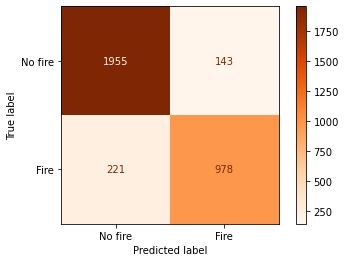

In [130]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, vote.predict(X_test)).ravel()
metrics.plot_confusion_matrix(vote, X_test, y_test, cmap='Oranges', display_labels=['No fire', 'Fire']);

In [131]:
vote_preds = vote.predict(X_test)

In [158]:
metrics.roc_auc_score(y_test, rf_preds)
print(metrics.recall_score(y_test, rf_preds))
print(metrics.precision_score(y_test, rf_preds))

0.8365304420350292
0.8351373855120733


In [159]:
metrics.roc_auc_score(y_test, vote_preds)
print(metrics.recall_score(y_test, vote_preds))
print(metrics.precision_score(y_test, vote_preds))

0.8156797331109258
0.872435325602141


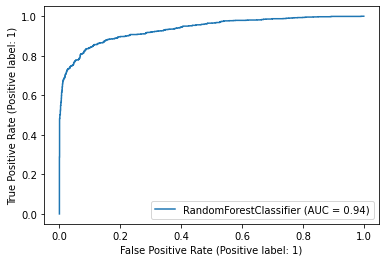

In [138]:
metrics.plot_roc_curve(rf, X_test, y_test);

In [114]:
n_input = X_train.shape[1]

model = Sequential()
model.add(BatchNormalization())
model.add(Dense(128, input_shape=(n_input,), activation='relu'))
model.add(Dropout(.05))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='bce', optimizer='adam', metrics=['acc', 'Recall', 'Precision'])

# early_stop = EarlyStopping(monitor='val_loss', patience=, verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

model.evaluate(X_test, y_test)

Epoch 1/100
61/61 [==============================] - 1s 8ms/step - loss: 0.5033 - acc: 0.7400 - recall: 0.6132 - precision: 0.6473 - val_loss: 32.2541 - val_acc: 0.6363 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4790 - acc: 0.7596 - recall: 0.6871 - precision: 0.6602 - val_loss: 9.2443 - val_acc: 0.3637 - val_recall: 1.0000 - val_precision: 0.3637
Epoch 3/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4768 - acc: 0.7602 - recall: 0.6788 - precision: 0.6640 - val_loss: 8.6091 - val_acc: 0.3637 - val_recall: 1.0000 - val_precision: 0.3637
Epoch 4/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4719 - acc: 0.7624 - recall: 0.7127 - precision: 0.6575 - val_loss: 2.7837 - val_acc: 0.3676 - val_recall: 1.0000 - val_precision: 0.3651
Epoch 5/100
61/61 [==============================] - 0s 2ms/step - loss: 0.4675 - acc: 0.7662 - recall: 0.6925 - precision: 0.6703 - val_lo

[0.4007240831851959,
 0.8316651582717896,
 0.7706422209739685,
 0.7674418687820435]

In [116]:
history_df = pd.DataFrame(history.history)
history_df.sort_values(by='acc', ascending=False)

,loss,acc,recall,precision,val_loss,val_acc,val_recall,val_precision
94,0.308069,0.861266,0.806417,0.808457,0.408009,0.831059,0.798165,0.752358
98,0.305065,0.858666,0.806056,0.802873,0.410758,0.820443,0.814846,0.725316
87,0.314826,0.858666,0.803893,0.804183,0.404084,0.821959,0.776480,0.744800
83,0.320519,0.858406,0.806777,0.801863,0.406357,0.830452,0.790659,0.754777
99,0.308410,0.858146,0.807138,0.801073,0.400724,0.831665,0.770642,0.767442
95,0.307645,0.857756,0.819394,0.793091,0.411766,0.831665,0.795663,0.754747
92,0.315238,0.857756,0.801730,0.803468,0.409159,0.832575,0.781485,0.763651
89,0.313725,0.856846,0.805696,0.799070,0.408551,0.828025,0.812344,0.740122
91,0.314751,0.856326,0.799207,0.801808,0.406970,0.832575,0.746455,0.783027
88,0.318553,0.856196,0.794521,0.804380,0.403263,0.829845,0.786489,0.755609
